In [78]:
using Plots
using LinearAlgebra
using BenchmarkTools
using SparseArrays
using DataFrames
using Statistics

# Week 4 - Boundary Value Problems and the Finite Difference Method
## Kiran Shila - U54532811

### Part 1 - Finite Difference Laplace Equation

So first we are going to write the function that calculates the "A" Matrix that describes the operator on the source vector b

For this function, I am going to allow the user to input the "dirichlet" conditions for the top and bottom bounds in 1D

In [2]:
"""
    generate1DLaplaceCFD(length,lowerBound,upperBound)

    This function generates the 1D centered finite-difference to solve the laplace equation.
"""
function generate1DLaplaceCFD(length::Int64)
    mainDiagonal = fill(2,length)
    sideDiagonals = fill(-1,length-1)
    return SymTridiagonal(mainDiagonal,sideDiagonals)
end

generate1DLaplaceCFD

In [3]:
A = generate1DLaplaceCFD(100)

100×100 SymTridiagonal{Int64,Array{Int64,1}}:
  2  -1   ⋅   ⋅   ⋅   ⋅   ⋅   ⋅   ⋅  …   ⋅   ⋅   ⋅   ⋅   ⋅   ⋅   ⋅   ⋅   ⋅
 -1   2  -1   ⋅   ⋅   ⋅   ⋅   ⋅   ⋅      ⋅   ⋅   ⋅   ⋅   ⋅   ⋅   ⋅   ⋅   ⋅
  ⋅  -1   2  -1   ⋅   ⋅   ⋅   ⋅   ⋅      ⋅   ⋅   ⋅   ⋅   ⋅   ⋅   ⋅   ⋅   ⋅
  ⋅   ⋅  -1   2  -1   ⋅   ⋅   ⋅   ⋅      ⋅   ⋅   ⋅   ⋅   ⋅   ⋅   ⋅   ⋅   ⋅
  ⋅   ⋅   ⋅  -1   2  -1   ⋅   ⋅   ⋅      ⋅   ⋅   ⋅   ⋅   ⋅   ⋅   ⋅   ⋅   ⋅
  ⋅   ⋅   ⋅   ⋅  -1   2  -1   ⋅   ⋅  …   ⋅   ⋅   ⋅   ⋅   ⋅   ⋅   ⋅   ⋅   ⋅
  ⋅   ⋅   ⋅   ⋅   ⋅  -1   2  -1   ⋅      ⋅   ⋅   ⋅   ⋅   ⋅   ⋅   ⋅   ⋅   ⋅
  ⋅   ⋅   ⋅   ⋅   ⋅   ⋅  -1   2  -1      ⋅   ⋅   ⋅   ⋅   ⋅   ⋅   ⋅   ⋅   ⋅
  ⋅   ⋅   ⋅   ⋅   ⋅   ⋅   ⋅  -1   2      ⋅   ⋅   ⋅   ⋅   ⋅   ⋅   ⋅   ⋅   ⋅
  ⋅   ⋅   ⋅   ⋅   ⋅   ⋅   ⋅   ⋅  -1      ⋅   ⋅   ⋅   ⋅   ⋅   ⋅   ⋅   ⋅   ⋅
  ⋅   ⋅   ⋅   ⋅   ⋅   ⋅   ⋅   ⋅   ⋅  …   ⋅   ⋅   ⋅   ⋅   ⋅   ⋅   ⋅   ⋅   ⋅
  ⋅   ⋅   ⋅   ⋅   ⋅   ⋅   ⋅   ⋅   ⋅      ⋅   ⋅   ⋅   ⋅   ⋅   ⋅   ⋅   ⋅   ⋅
  ⋅   ⋅   ⋅   ⋅   ⋅   ⋅   ⋅   ⋅   ⋅      ⋅   ⋅   ⋅   ⋅

Now we generate the source vector $\vec{B}$

The first entry is the lower bound, 0V and the upper bound is 1V

In [4]:
b = [1;zeros(98);0]

100-element Array{Float64,1}:
 1.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮  
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

And solve - I'm using LAPACK's solver, thats why the type of A is SymTridiagonal, there are special solvers for it.

In [5]:
x = A\b

100-element Array{Float64,1}:
 0.9900990099009893  
 0.9801980198019786  
 0.970297029702968   
 0.9603960396039576  
 0.950495049504947   
 0.9405940594059363  
 0.9306930693069255  
 0.920792079207915   
 0.9108910891089045  
 0.900990099009894   
 0.8910891089108834  
 0.8811881188118728  
 0.8712871287128622  
 ⋮                   
 0.11881188118811689 
 0.1089108910891072  
 0.0990099009900975  
 0.0891089108910878  
 0.07920792079207808 
 0.06930693069306836 
 0.059405940594058605
 0.04950495049504884 
 0.039603960396039084
 0.029702970297029313
 0.019801980198019542
 0.009900990099009771

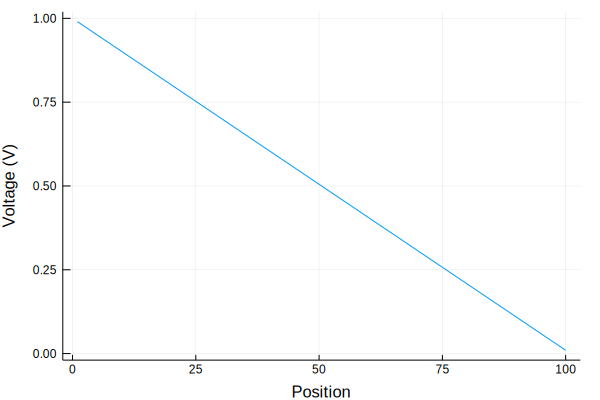

In [6]:
plot(x,legend=false,xlabel="Position",ylabel="Voltage (V)")

Hey look, it's linear - as it should be.

Lets compare the speed when we ramp up the number of points for the different implementations.

First as the built-in tridiagonal type

In [107]:
numPoints = 100
A = generate1DLaplaceCFD(numPoints)
b = [0;fill(0,numPoints-2);1]
time1 = @benchmark A\b

BenchmarkTools.Trial: 
  memory estimate:  2.67 KiB
  allocs estimate:  5
  --------------
  minimum time:     1.760 μs (0.00% GC)
  median time:      2.369 μs (0.00% GC)
  mean time:        2.852 μs (10.54% GC)
  maximum time:     322.773 μs (98.78% GC)
  --------------
  samples:          10000
  evals/sample:     10

Now as the generic "sparse" matrix

In [110]:
numPoints = 100
A = sparse(float(generate1DLaplaceCFD(numPoints))) # We need to cast to float as the sparse solver doesn't work for ints
b = [0;fill(0,numPoints-2);1.]
time2 = @benchmark A\b

BenchmarkTools.Trial: 
  memory estimate:  42.36 KiB
  allocs estimate:  47
  --------------
  minimum time:     34.914 μs (0.00% GC)
  median time:      38.156 μs (0.00% GC)
  mean time:        62.848 μs (28.86% GC)
  maximum time:     116.360 ms (98.41% GC)
  --------------
  samples:          10000
  evals/sample:     1

And finally as a dense matrix

In [111]:
numPoints = Int64(100)
A = Array(generate1DLaplaceCFD(numPoints))
b = [0;fill(0,numPoints-2);1]
trial3 = @benchmark A\b

BenchmarkTools.Trial: 
  memory estimate:  79.98 KiB
  allocs estimate:  5
  --------------
  minimum time:     368.877 μs (0.00% GC)
  median time:      373.331 μs (0.00% GC)
  mean time:        407.691 μs (2.16% GC)
  maximum time:     3.510 ms (82.34% GC)
  --------------
  samples:          10000
  evals/sample:     1

So to compare the three

<center>

|   $\space$             | SymTridiagonal | SparseCSC |   Dense | 
|------------------------|:----------------:|:-----------:|:---------:|
| RAM Utilization (KiB)  |   2.67         |42.36      |79.98    |
| Mean Solving Time (μs) |  4.065         | 64.203    |449.684  |
    
</center>

Now for $10^6$ points

In [10]:
numPoints = Int64(1e6)
A = generate1DLaplaceCFD(numPoints)
b = [0;fill(0,numPoints-2);1]
@benchmark A\b

BenchmarkTools.Trial: 
  memory estimate:  22.89 MiB
  allocs estimate:  8
  --------------
  minimum time:     22.228 ms (8.84% GC)
  median time:      25.565 ms (7.53% GC)
  mean time:        26.070 ms (10.54% GC)
  maximum time:     129.685 ms (79.01% GC)
  --------------
  samples:          192
  evals/sample:     1

I'm not going to compare to the non-sparse version - it's going to crash my server

### Question 1 - Why wasn't conductivity part of the equation

Conductivitiy is linear and not dependent on voltage. Between two points of a given voltage, the voltage gradiant MUST be linear because conductivity is linear. Therefore, solving for the "diffusion" of voltage won't be dependent on the conductivity

FIXME

### Part 2 - Finite Difference Poisson Equation

$\textbf{A}$ is the same here, except we modify our source vector $\vec{B}$

In [163]:
numPoints = 1000
A = generate1DLaplaceCFD(numPoints)
b = zeros(Float64,numPoints)
b[1] = 1
x = A\b

1000-element Array{Float64,1}:
 0.9990009990009983   
 0.9980019980019965   
 0.9970029970029949   
 0.9960039960039933   
 0.9950049950049916   
 0.9940059940059899   
 0.993006993006988    
 0.9920079920079863   
 0.9910089910089847   
 0.990009990009983    
 0.9890109890109813   
 0.9880119880119794   
 0.9870129870129777   
 ⋮                    
 0.011988011988009533 
 0.010989010989008736 
 0.009990009990007943 
 0.008991008991007148 
 0.007992007992006353 
 0.0069930069930055575
 0.005994005994004764 
 0.004995004995003969 
 0.0039960039960031755
 0.002997002997002381 
 0.0019980019980015873
 0.0009990009990007937

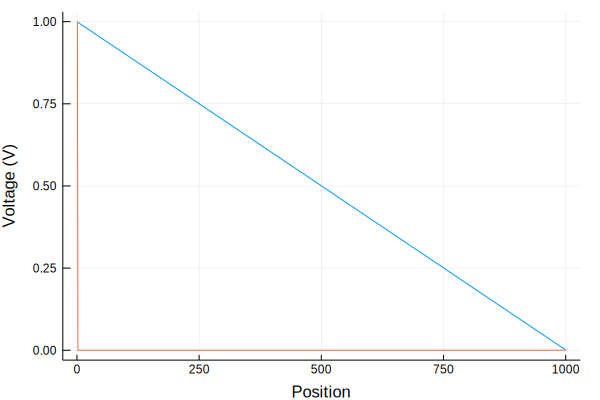

In [164]:
plot(x,legend=false,xlabel="Position",ylabel="Voltage (V)")
plot!(b,legend=false)